# Import Libraries

In [1]:
%matplotlib inline
# python libraries
from copy import deepcopy
from matplotlib.patches import Rectangle
import natsort as ns
from multiprocessing import cpu_count
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, FloatSlider
from sklearn.manifold import TSNE
import sys

# custom libraries
from helpers.helpers import *
from helpers.data_augment import *
from keras_helpers.unet import *
from keras_helpers.helpers import *
from keras_helpers.callbacks import *

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from sklearn import decomposition
from sklearn.utils import class_weight
from keras.utils import to_categorical
from keras.models import load_model

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/opt/conda/envs/python36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9375469899822011517
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10974989517
locality {
  bus_id: 2
}
incarnation: 4787029696436585355
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:82:00.0, compute capability: 6.1"
]


In [2]:
# Meta-Parameters
#base_dir = '/Users/cyrilwendl/Documents/EPFL'  # for local machine
#base_dir = '/home/cyrilwendl'  # for GCE
base_dir = '/raid/home/cwendl'  # for guanabana

class_to_remove = 3

In [3]:
# custom libraries
sys.path.append(base_dir + '/SIE-Master/Code') # Path to density Tree package
sys.path.append(base_dir + '/SIE-Master/Code/density_tree') # Path to density Tree package
from density_tree.density_forest import *
from density_tree.helpers import print_density_tree_latex

# Load Images

In [4]:
path = os.getcwd()

im_dir = r'' + path + '/Zurich_dataset/images_tif/'
gt_dir = r'' + path + '/Zurich_dataset/groundtruth/'

im_names = ns.natsorted(os.listdir(im_dir))
gt_names = ns.natsorted(os.listdir(gt_dir))
print("images: %i " % len(im_names))
print("ground truth images: %i " % len(gt_names))

imgs = np.asarray([im_load(im_dir + im_name) for im_name in im_names])
gt = np.asarray([im_load(gt_dir + gt_name) for gt_name in gt_names])

# histogram stretching
imgs_eq = imgs_stretch_eq(imgs)
imgs = imgs_eq  # continue using stretched image

images: 20 
ground truth images: 20 


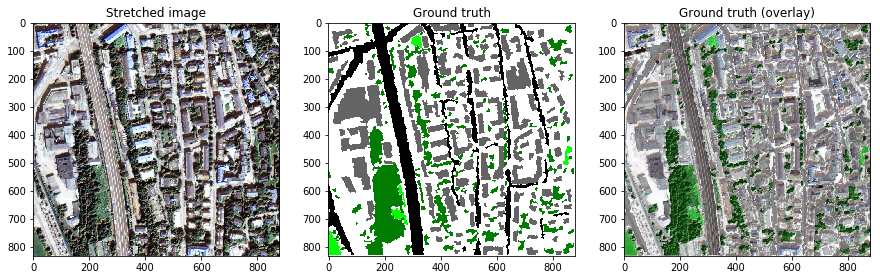

In [5]:
# Show image, its groundtruth image and overlay (to verify matching)
i = 1
alpha=.6
overlay = imgs_eq[i][:, :, :3] * alpha + gt[i] / 255 * (1-alpha)

fig, axes = plt.subplots(1,3)
fig.set_size_inches(15,7)
axes[0].imshow(imgs[i][..., :3], cmap='Greys_r')
axes[1].imshow(gt[i]/255, cmap='Greys_r')
axes[2].imshow(overlay, cmap='Greys_r')
axes[0].set_title("Stretched image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
plt.show()

## GT to labels
Next, we need to convert the ground truth (colors) to labels 

In [6]:
legend = OrderedDict((('Background', [255, 255, 255]),
                      ('Roads', [0, 0, 0]),
                      ('Buildings', [100, 100, 100]),
                      ('Trees', [0, 125, 0]),
                      ('Grass', [0, 255, 0]),
                      ('Bare Soil', [150, 80, 0]),
                      ('Water', [0, 0, 150]),
                      ('Railways', [255, 255, 0]),
                      ('Swimming Pools', [150, 150, 255])))

# get class names by increasing value (as done above)
names, colors = [], []
for name, color in legend.items():
    names.append(name)
    colors.append(color)

gt_maj_label = gt_color_to_label(gt, colors)

100%|██████████| 9/9 [00:05<00:00,  1.64it/s]


In [7]:
# Load Images
def flatten(l):
    return [item for sublist in l for item in sublist]


flat_labels = flatten(flatten(gt_maj_label))
print("Unique Labels in GT: ", np.unique(flat_labels))
print(np.shape(gt_maj_label))
gt = gt_maj_label

Unique Labels in GT:  [0. 1. 2. 3. 4. 5. 6. 7. 8.]
(20,)


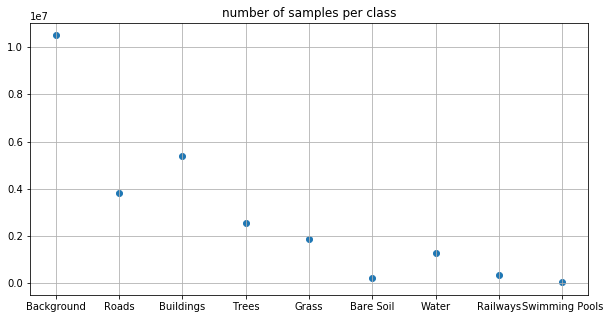

In [8]:
# print some statistics for the class distribution
unique, counts = np.unique(flat_labels, return_counts=True)
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(unique, counts)
ax.set_title('number of samples per class')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names)
ax.grid()
plt.show()

## Get patches

In [9]:
# Get patches
patch_size = 64
stride_train = 64  # has to be <= patch_size
stride_test = 32  # has to be <= patch_size

# ids for training, validation and test sets (0-19)
ids_train = np.arange(0, 12)
ids_val = np.arange(12, 16)
ids_test = np.arange(16, 20)

# get training, test and validation sets
x_train = get_padded_patches(imgs[ids_train], patch_size=patch_size, stride=stride_train)
x_val = get_padded_patches(imgs[ids_val], patch_size=patch_size, stride=stride_train)
x_test = get_padded_patches(imgs[ids_test], patch_size=patch_size, stride=stride_test)
x_test_nostride = get_padded_patches(imgs[ids_test], patch_size=patch_size, stride=patch_size)

y_train = get_gt_patches(gt[ids_train], patch_size=patch_size, stride=stride_train)
y_val = get_gt_patches(gt[ids_val], patch_size=patch_size, stride=stride_train)
y_test = get_gt_patches(gt[ids_test], patch_size=patch_size, stride=stride_test)
y_test_nostride = get_gt_patches(gt[ids_test], patch_size=patch_size, stride=patch_size)

print(x_test.shape)
print(x_test_nostride.shape)
print(y_test_nostride.shape)

100%|██████████| 4/4 [00:00<00:00, 95.87it/s]

(3902, 64, 64, 4)
(964, 64, 64, 4)
(964, 64, 64)


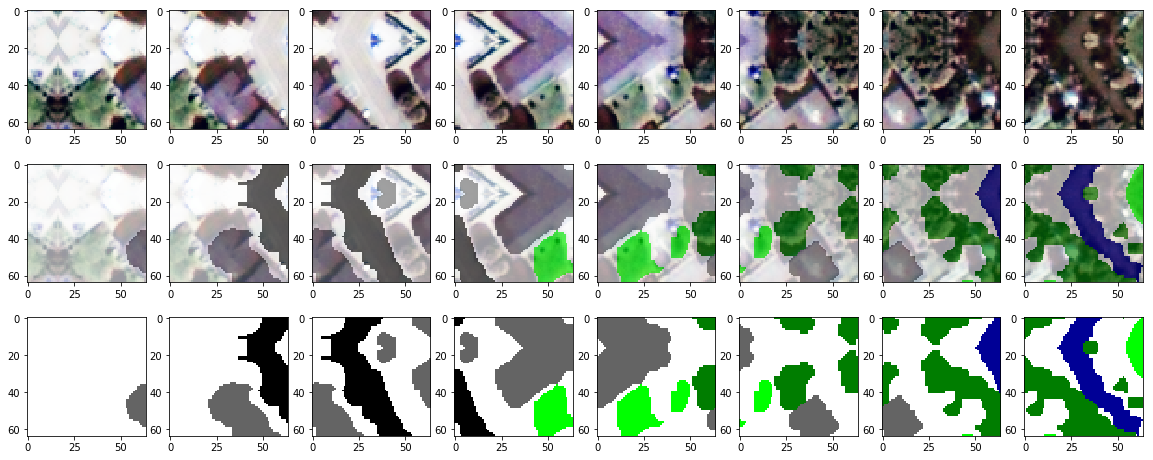

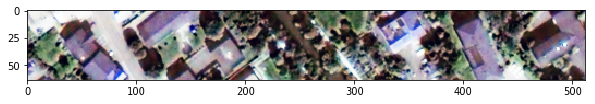

In [10]:
# visualize some patches 
imgs_row = 8
fig, axes = plt.subplots(3, imgs_row)
fig.set_size_inches(20, 8)
offset = 0
alpha = .6
for i in range(offset, offset + imgs_row):
    axes[0][i - offset].imshow(x_test[i][..., :3])  # images
    axes[1][i - offset].imshow(
        gt_label_to_color(y_test[i], colors) * alpha + x_test[i][..., :3] * (1 - alpha))  # ground truth (overlay)
    axes[2][i - offset].imshow(gt_label_to_color(y_test[i], colors))  # ground truth

# corresponding part of image
plt.figure(figsize=(10, 5))
plt.imshow(imgs[16][:64, :64 * 8, :3])

# Keras CNN

Data Split: 
- Training: 12 images
- Validation: 4 images
- Test: 4 images

Tested Architectures: 

| Model | Patch Size | Data Augmentations | Number of Parameters | Testing Precision (avg) | Testing Recall (avg) | Testing f1 score (avg) | Validation / Test accuracy |
| ------- | ------- | ------- | ------- | ------- | ------- |
| U-Net | 64 | Rot 90°, Flipping  | 7,828,200 | 0.87 | 0.858 | 0.86 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.69 | 0.61 | 0.64 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.90 | 0.89 | 0.89 | v |

In [11]:
# create copies of original data
y_train_label = y_train.copy()
y_val_label = y_val.copy()
y_test_label = y_test.copy()

In [12]:
# get class weights
labels_unique = np.unique(y_train.flatten())
print(labels_unique)
class_weights = class_weight.compute_class_weight('balanced', labels_unique, y_train.flatten())
class_weights[0] = 0  # give less weight to background label class
class_weights[5] = 7  # give less weight to bare soil class
class_weights[8] = 7  # give less weight to swimming pool class

print("Class weights:")
for i, w in enumerate(class_weights):
    print("%15s: %3.3f" % (names[i], w))

[0 1 2 3 4 5 6 7 8]
Class weights:
     Background: 0.000
          Roads: 0.757
      Buildings: 0.480
          Trees: 1.508
          Grass: 2.105
      Bare Soil: 7.000
          Water: 2.006
       Railways: 6.211
 Swimming Pools: 7.000


In [13]:
n_classes = 9

# convert to numpy arrays
x_train = np.asarray(x_train)
x_val = np.asarray(x_val)
x_test = np.asarray(x_test)

# make y data categorical
y_train = to_categorical(y_train_label, n_classes)
y_val = to_categorical(y_val_label, n_classes)

# remove class
classes_to_keep = np.asarray([x for x in range(1, n_classes) if x != class_to_remove])

names_keep = np.asarray(names)[classes_to_keep]
names_keep = names_keep.tolist()
print("classes to keep: " + str(names_keep))

y_train = y_train[..., classes_to_keep]
y_val = y_val[..., classes_to_keep]
n_classes = len(classes_to_keep)
class_weights = class_weights[classes_to_keep]

# print shapes of variables
for var in x_train, y_train, x_val, y_val:
    print(np.shape(var))

classes to keep: ['Roads', 'Buildings', 'Grass', 'Bare Soil', 'Water', 'Railways', 'Swimming Pools']
(3897, 64, 64, 4)
(3897, 64, 64, 7)
(1117, 64, 64, 4)
(1117, 64, 64, 7)


## Train CNN

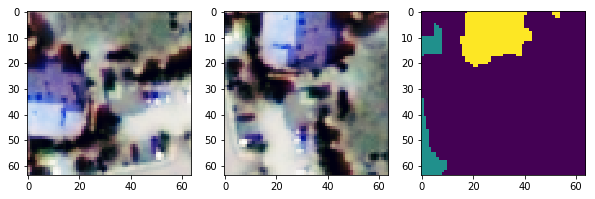

In [14]:
# data augmentation
img_idx = 14
im_vis, gt_vis = augment_images_and_gt(x_train[img_idx], y_train_label[img_idx], rf_h=True,
                                                   rf_v=True, rot=True)

fig, axes = plt.subplots(1, 3)
fig.set_size_inches((10, 5))
axes[0].imshow(x_train[img_idx][..., :3])
axes[1].imshow(im_vis[..., :3])
axes[2].imshow(gt_vis)
plt.show()

In [15]:
# callbacks (evaluated every epoch)
# show loss and accuracy figures after each epoch
callback_plot = PlotLosses()

# stop early if after several epochs the accuracy doesn't improve
callback_earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=24, verbose=1, mode='auto')

# decrease learning rate when accuracy stops improving
callback_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, verbose=1, mode='auto',
                                epsilon=1e-4, cooldown=0, min_lr=1e-8)

# checkpoint to save weights at every epoch (in case of interruption)
file_path = "weights-improvement.hdf5"
callback_checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

callback_tensorboard = TensorBoard(log_dir='./tensorboard', histogram_freq=0, write_graph=True, write_images=True)

# model setup
batch_size = 20
epochs = 300


def model_train(model, data_augmentation):
    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(batch_generator(x_train, y_train,
                                        batch_size=batch_size, data_augmentation=data_augmentation),
                        steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))),
                        epochs=epochs,
                        verbose=1,
                        class_weight=class_weights,  # weights for loss function
                        validation_data=(x_val, y_val),
                        callbacks=[callback_earlystop,
                                   callback_lr,
                                   #callback_checkpoint,
                                   callback_plot,
                                   callback_tensorboard],
                        workers=cpu_count(),
                        use_multiprocessing=True)

<Figure size 432x288 with 0 Axes>

In [16]:
# train or load model
# train the model
#model_unet = get_unet(n_classes, x_train.shape[1:])
#model_train(model_unet, data_augmentation=True)
#model_unet.save('models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower() + '_2.h5')  # save model, weights

In [17]:
# load model
name_model = path + '/models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower() + '.h5'    
model_unet = load_model(name_model, custom_objects={'fn': ignore_background_class_accuracy(0)})

# Prediction on Test Set

In [18]:
# get prediction
y_pred = model_unet.predict(x_test, batch_size=20, verbose=1)

# prediction patches without overlapping patches
y_pred = np.concatenate(remove_overlap(imgs, y_pred, ids_test, 64, 32))

# get label
y_pred_label = get_y_pred_labels(y_pred, class_to_remove=class_to_remove)

# Get accuracy as margin between highest and second highest class
y_pred_acc = get_accuracy_probas(y_pred)

3902/3902 [==============================] - 4s 946us/step


100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


In [19]:
# prediction image
y_pred_acc_imgs = [convert_patches_to_image(imgs, y_pred_acc[...,np.newaxis],
                                       img_idx=idx_im, img_start=ids_test[0], patch_size=64,
                                       stride=64) for idx_im in ids_test]

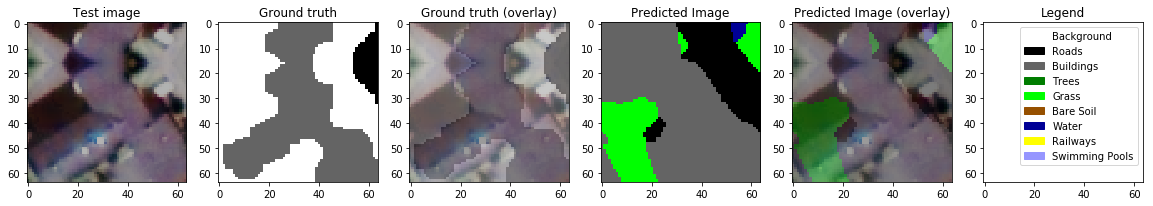

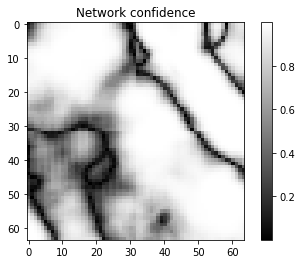

In [20]:
# plot prediction results
im_idx = 15
alpha = .3  # for overlay
fig, axes = plt.subplots(1, 6)
fig.set_size_inches(20, 20)
fig_im = x_test[im_idx][..., :3] * (1 - alpha)
fig_test = gt_label_to_color(y_test_label[im_idx], colors)
fig_pred = gt_label_to_color(y_pred_label[im_idx], colors)

# plots
axes[0].imshow(fig_im)
axes[1].imshow(fig_test)
axes[2].imshow(fig_test * alpha + fig_im * (1 - alpha))
axes[3].imshow(fig_pred)
axes[4].imshow(fig_pred * alpha + fig_im * (1 - alpha))
axes[5].imshow(fig_im * 0 + 1)

# titles
axes[0].set_title("Test image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
axes[3].set_title("Predicted Image")
axes[4].set_title("Predicted Image (overlay)")
axes[5].set_title("Legend")

# legend
legend_data = [[l[0], l[1]] for l in legend.items()]
handles = [Rectangle((0, 0), 1, 1, color=[v / 255 for v in c]) for n, c in legend_data]
labels = np.asarray([n for n, c in legend_data])
axes[5].legend(handles, labels)

# show certitude by network
fig = plt.figure()
plt.imshow(y_pred_acc[im_idx], cmap='gray')
plt.title("Network confidence")
plt.colorbar()

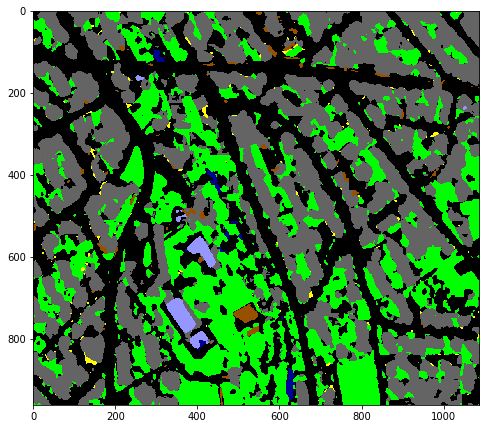

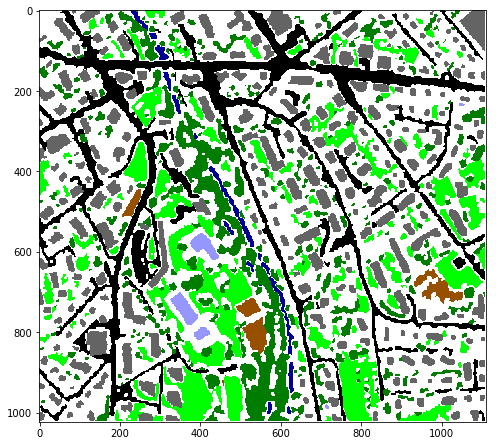

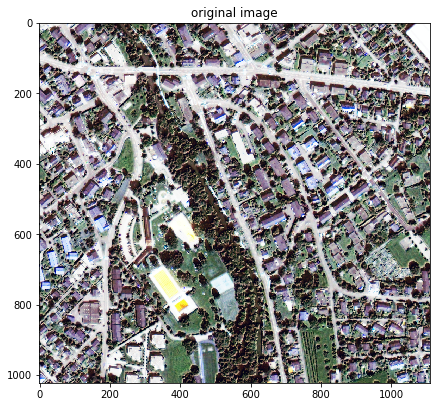

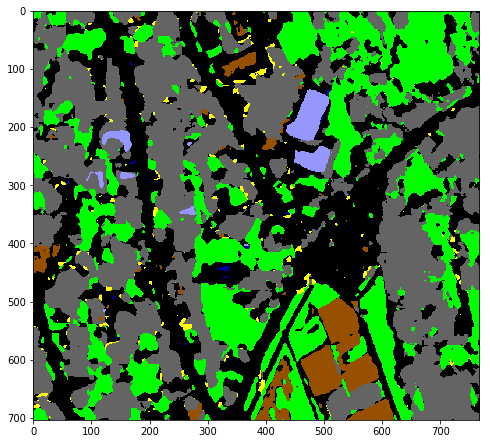

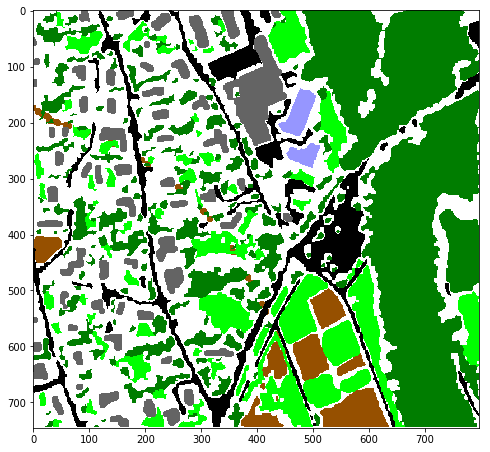

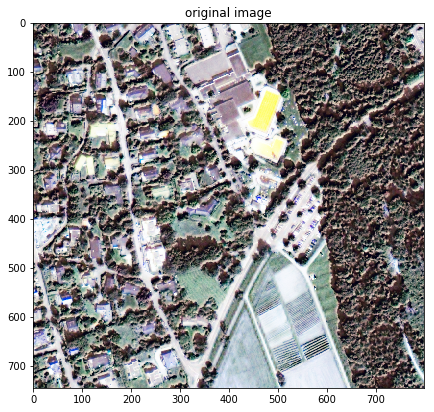

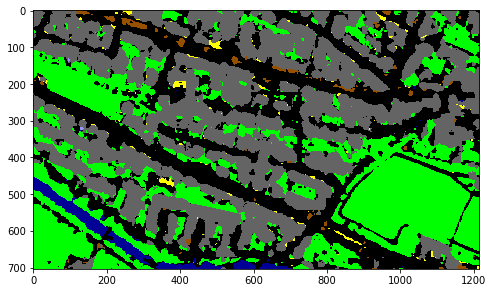

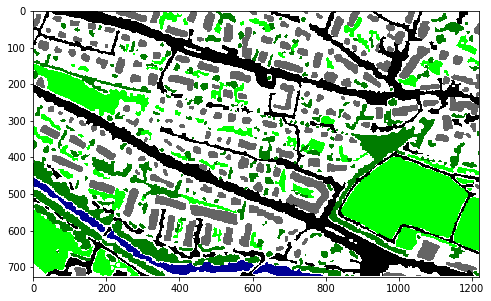

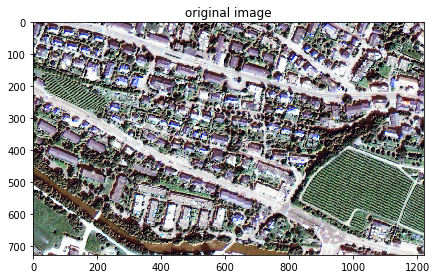

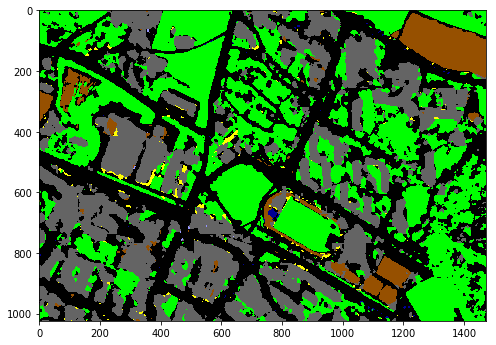

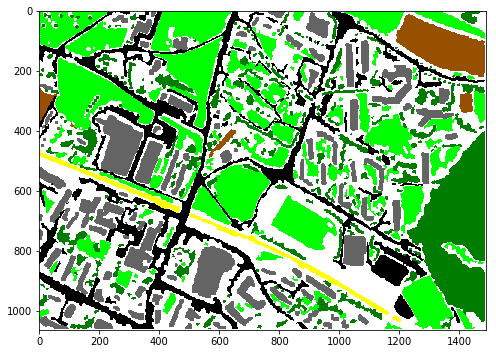

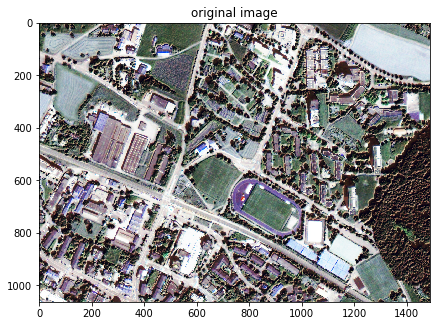

In [21]:
y_pred_im = [convert_patches_to_image(imgs, gt_label_to_color(y_pred_label, colors), img_idx=i, img_start=16, patch_size=64,
                             stride=64) for i in ids_test]

for img_idx in ids_test:
    # Pred
    plt.figure(figsize=(8,8))
    plt.imshow(y_pred_im[img_idx-16])  # prediction
    plt.savefig("../Figures/Pred/im_" + str(img_idx+1) + "_pred_wo_cl_" + str(class_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)

    # GT
    plt.figure(figsize=(8,8))
    plt.imshow(gt_label_to_color(gt[img_idx],colors))  # gt stitched together


    # show also original image
    plt.figure(figsize=(7, 7))
    plt.imshow(imgs[img_idx][:, :, :3])
    plt.savefig("../Figures/Im/im_" + str(img_idx+1) + ".pdf", bbox_inches='tight', pad_inches=0)
    plt.title("original image")

# Accuracy Metrics (Test Set)

In [22]:
# Accuracy metrics
y_pred_flattened= np.asarray(flatten(flatten(y_pred_label))).astype('int')
y_test_flattened= np.asarray(flatten(flatten(y_test_nostride))).astype('int')

# mask background and removed classes for evaluation metrics
filter_items = (y_test_flattened != 0) & (y_test_flattened != class_to_remove)

# Class accuracy, average accuracy
print(metrics.classification_report(
    y_test_flattened[filter_items],
    y_pred_flattened[filter_items],
    target_names=names_keep,
    digits=3))


# Overall accuracy
OA = metrics.accuracy_score(y_test_flattened[filter_items], y_pred_flattened[filter_items])
print("Overall accuracy: %.3f %%" % (OA*100))

                precision    recall  f1-score   support

         Roads      0.834     0.895     0.864    520742
     Buildings      0.877     0.919     0.897    470587
         Grass      0.983     0.881     0.929    612397
     Bare Soil      0.591     0.746     0.659     66093
         Water      0.961     0.593     0.734     18705
      Railways      0.017     0.008     0.011     18526
Swimming Pools      0.821     0.952     0.881     10386

   avg / total      0.882     0.878     0.878   1717436

Overall accuracy: 87.839 %


In [23]:
# print to log file
import pandas as pd
precision, recall, fscore, support = metrics.precision_recall_fscore_support(y_test_flattened[filter_items], y_pred_flattened[filter_items])
df = pd.DataFrame(data={'Precision':precision,
                        'Recall':recall,
                       'f1-score':fscore,
                       'support':support}, index=names_keep)

df.index.name = 'Class'
with open("models_out/acc_class_" + str(class_to_remove) + ".csv", 'w') as f:
    print(df.to_latex(float_format='%.3f'), file=f)  # Python 3.x

In [24]:
#AA_CNN=[87.098, 81.905, 87.839, 81.076, 81.236, 83.891, 81.091, 81.451] #CNN,accuracies
#print("AA for all models: %.3f"%(np.dot(AA_CNN,support)/sum(support)))

# Certainty using Density Forest

In [25]:
# image, layer indexes
layer_idx = -2
img_idx = 2
batch_size = 20

# get activations for training Density Forest
act_train = get_activations(imgs, model_unet, layer_idx, x_train, ids_train, batch_size=160, patch_size=64, stride=64)

100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


In [26]:
# get activations for seen classes

# retain only activation weights for which there is a ground truth
filter_seen = (y_train_label != 0) & (y_train_label != class_to_remove)
act_train_seen = np.concatenate(act_train)[filter_seen] 

# all but those belonging to background
act_train = np.concatenate(act_train)[y_train_label != 0]

In [27]:
# get activations for testing Density Forest
act_test = get_activations(imgs, model_unet, layer_idx, x_test, ids_test, batch_size=160, patch_size=64, stride=32)

# remove test activations overlap
act_test = remove_overlap(imgs, np.concatenate(act_test), ids_test, patch_size=64, stride=32) 

# all labels, including background
act_test = np.concatenate(act_test, axis=0)[y_test_nostride < np.infty] # convert to 1D

100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


In [28]:
# get balanced data subset to show in figure
pts_per_class = 100  # same number of points per class
dataset_subset_indices = []
for class_label in range(1, 9):
    ds_subset_ind = np.where(y_test_nostride[y_test_nostride<np.infty]==class_label)[0]
    dataset_subset_indices.append(np.random.choice(ds_subset_ind, size=pts_per_class, replace=False))

In [29]:
def plot_t_sne(tsne_all, class_to_remove, classes_to_keep, export_tag):
    # plot t-SNE (before PCA)
    fig = plt.figure(figsize=(8, 8))
    for i, class_label in enumerate(classes_to_keep):
        ind_data = np.arange(pts_per_class *(class_label-1),pts_per_class * class_label)
        plt.scatter(tsne_all[ind_data,0], tsne_all[ind_data,1],
                    c=np.asarray(colors)[class_label]/255, marker='o')

    ind_data = np.arange(pts_per_class *(class_to_remove-1), pts_per_class * class_to_remove)
    plt.scatter(tsne_all[ind_data, 0], tsne_all[ind_data, 1],
                c=np.asarray(colors)[class_to_remove]/255, marker='x',)
    names_legend = names_keep.copy()
    names_legend.append('unseen class (' + names[class_to_remove] + ')')
    plt.legend(names_legend)
    plt.axis('off')
    plt.savefig("../Figures/PCA/t-SNE_" + names[class_to_remove] + "_" +
                export_tag + "_PCA.pdf", bbox_inches='tight', pad_inches=0)

In [30]:
# t-SNE visualization
#tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000)
#tsne_all = tsne.fit_transform(act_test[np.concatenate(dataset_subset_indices)])

In [31]:
#plot_t_sne(tsne_all, class_to_remove, classes_to_keep, "before")

In [32]:
# create density tree for activation weights of training data
# PCA
pca = decomposition.PCA(n_components=5)
pca.fit(act_train)  # fit on training set without background pixels
n_components = np.alen(pca.explained_variance_ratio_)
print("Variance explained by first %i components: %.2f" % (
    n_components, sum(pca.explained_variance_ratio_)))

# transform training activations
act_train_seen = pca.transform(act_train_seen)

# transform test set activations
act_test = pca.transform(act_test)

Variance explained by first 5 components: 0.97


In [33]:
# t-SNE visualization after PCA
#tsne_all = tsne.fit_transform(act_test[np.concatenate(dataset_subset_indices)])

# plot
#plot_t_sne(tsne_all, class_to_remove, classes_to_keep, "after")

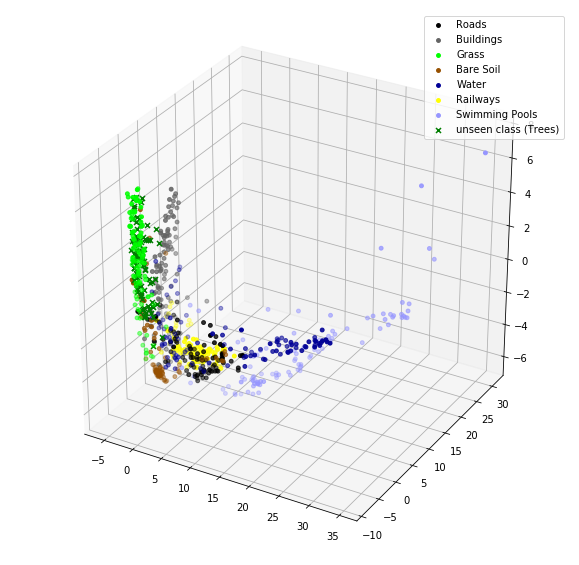

Variance explained by first 3 components: 0.91


In [34]:
# plot PCA point
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=Axes3D.name)

for i, class_keep in enumerate(classes_to_keep):
    ind_data = dataset_subset_indices[class_keep-1]
    plot_data = act_test[ind_data]
    plot_color = np.ones(np.shape(plot_data))*class_keep
    ax.scatter(plot_data[:, 0], plot_data[:, 1], zs=plot_data[:, 2], 
               c=np.asarray(colors)[class_keep]/255, s=15, depthshade=True, marker='o')


ind_data = dataset_subset_indices[class_to_remove-1]
ax.scatter(act_test[ind_data,0], act_test[ind_data,1], zs=act_test[ind_data,2],
           c=np.asarray(colors)[class_to_remove]/255, s=25, marker='x', depthshade=False)


names_legend = names_keep.copy()
names_legend.append('unseen class (' + names[class_to_remove] + ')')
ax.legend(names_legend)
plt.savefig("../Figures/PCA/pca_components_3d_" + names[class_to_remove] + ".pdf", bbox_inches='tight', pad_inches=0)
plt.show()

print("Variance explained by first 3 components: %.2f" % np.sum(pca.explained_variance_ratio_[:3]))

## Train Density Forest

# Parameters importance:
- `n_trees`: minor relevance (10 is enough)
- `min_subset`: important, smaller number <-> more clusters (requires `subset_data` to be high enough)
- `subset_data`: irrelevant, but should be higher if `min_subset` is lower
- `max_depth`: important, greater depth <-> more clusters
- `fact_improvement`: important, smaller minimum factor <-> more clusters
- `n_max_dim`: unimportant, better to set to 0


In [90]:
warnings.filterwarnings("ignore")
n_trees = 10
max_depth = 13
subset_data = .08
min_subset = .001
n_max_dim = 0
fact_improvement = .07


print("Number of points on which to train each tree: %i" % int(len(act_train_seen) * subset_data))
print("Minimum number of points in each leaf: %i" % int(len(act_train_seen) * subset_data * min_subset))

root_nodes_seen = density_forest_create(act_train_seen, max_depth=max_depth, min_subset=min_subset, n_trees=n_trees, 
                                        n_max_dim=n_max_dim, subsample_pct=subset_data, n_jobs=-1, verbose=10, 
                                        fact_improvement=fact_improvement)

Number of points on which to train each tree: 653624
Minimum number of points in each leaf: 653


[Parallel(n_jobs=40)]: Done   3 out of  10 | elapsed:  9.1min remaining: 21.2min
[Parallel(n_jobs=40)]: Done   5 out of  10 | elapsed:  9.1min remaining:  9.1min
[Parallel(n_jobs=40)]: Done   7 out of  10 | elapsed:  9.1min remaining:  3.9min
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:  9.3min finished


In [ ]:
# get probabilities for all images
def get_probas(activations, root_nodes_seen, method = 'normal', n_jobs = 8, batch_size=10000, verbosity=2):
    steps = np.linspace(0,len(activations),len(activations)/batch_size,dtype='int')
    print("Total steps: %i" % len(steps))
    if n_jobs==-1:
        n_jobs=multiprocessing.cpu_count()
    print("Number of jobs: %i " % n_jobs)
    
    probas = Parallel(n_jobs=n_jobs, verbose=verbosity)(
        delayed(density_forest_traverse)(
            activations[steps[i]:steps[i+1], :], root_nodes_seen, thresh=.0001, method=method, standardize=False)
        for i in range(len(steps)-1))
    
    probas = np.concatenate(probas)
    if method == 'euclid': # (shorter distance = higher certainty)
        probas = 1-probas
    
    return probas
    
probas = get_probas(act_test, root_nodes_seen, n_jobs=-1, batch_size=10000, verbosity = 10)

Total steps: 394
Number of jobs: 40 


[Parallel(n_jobs=40)]: Done   5 tasks      | elapsed:   13.3s
[Parallel(n_jobs=40)]: Done  18 tasks      | elapsed:   38.9s
[Parallel(n_jobs=40)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:  1.7min
[Parallel(n_jobs=40)]: Done  65 tasks      | elapsed:  2.2min
[Parallel(n_jobs=40)]: Done  82 tasks      | elapsed:  2.8min
[Parallel(n_jobs=40)]: Done 101 tasks      | elapsed:  3.6min
[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:  4.3min
[Parallel(n_jobs=40)]: Done 141 tasks      | elapsed:  5.0min
[Parallel(n_jobs=40)]: Done 162 tasks      | elapsed:  5.8min
[Parallel(n_jobs=40)]: Done 185 tasks      | elapsed:  6.7min
[Parallel(n_jobs=40)]: Done 208 tasks      | elapsed:  7.6min


#### Post-Treatment

In [ ]:
# reshape probas to (n_patches, patch_size, patch_size)
patches_start = get_offset(imgs, 64, 64, 16, 16) # idx of first patch in image
patches_end = get_offset(imgs, 64, 64, 16, 20) # idx of first patch in image
n_patches = patches_end - patches_start
probas_seen_im = np.reshape(probas, (n_patches,patch_size,patch_size))

# transformations
#probas_seen_im[probas_seen_im==0]=1e-5  # for log
#probas_seen_im = np.log(probas_seen_im)
probas_seen_im -= np.nanmin(probas_seen_im)
probas_seen_im /=np.nanmax(probas_seen_im)
#probas_seen_im = 1-probas_seen_im

# remove outliers
#probas_seen_im[abs(probas_seen_im - np.nanmean(probas_seen_im)) > m * np.nanstd(probas_seen_im)] = np.nan

In [ ]:
from density_tree.helpers import print_density_tree_latex
from IPython.core.display import Image, display

In [ ]:
# save probabilities corresponding to an image in an array
probas_imgs = [] # (n_imgs, n_patches, patch_size, patch_size)
for idx_im in ids_test:
    patches_start = get_offset(imgs, 64, 64, 16, idx_im) # idx of first patch in image
    patches_end = get_offset(imgs, 64, 64, 16, idx_im+1) # idx of last patch in image
    probas_im = np.asarray(probas_seen_im[patches_start:patches_end])
    probas_imgs.append(probas_im)

#### Figures, Tables

In [ ]:
from helpers.helpers import imgs_stretch_eq

In [ ]:
for idx_im in ids_test:
    im_cert_out = convert_patches_to_image(imgs, probas_imgs[idx_im-16][..., np.newaxis],
                                           img_idx=idx_im, patch_size=64,
                                           stride=64, img_start=idx_im)

    
    im_cert_out = imgs_stretch_eq([im_cert_out])
    im_cert_out = im_cert_out[...,0][0]
    #im_cert_out = np.log(im_cert_out)
    #thresh=.01
    #im_cert_out = (im_cert_out>thresh)*1
    
    fig, axes = plt.subplots(2,1,figsize=(16, 20))
    axes[0].imshow(im_cert_out, interpolation='nearest', cmap='gray')
    axes[1].imshow(y_pred_acc_imgs[idx_im-16][...,0],cmap='gray')
    
    axes[0].set_title("Density Forest Confidence")
    axes[1].set_title("Network Confidence")
    im = ax.imshow(im_cert_out, cmap='gray')
    #fig.colorbar(im, ax=axes[0], orientation='horizontal')
    plt.savefig("../Figures/DF/im_" + str(idx_im + 1) + "_confidence_cl_" + str(class_to_remove) +".pdf", bbox_inches='tight', pad_inches=0);
    plt.show()

In [ ]:
# convert patches to image
idx_im = 17

# show certitude by network
# image, overlay
im_cert_out = convert_patches_to_image(imgs, probas_imgs[idx_im-16][..., np.newaxis],
                                       img_idx=idx_im, patch_size=64,
                                       stride=64, img_start=idx_im)

im_cert_out = imgs_stretch_eq([im_cert_out])[0]

def fig_uncertainty(thresh, save=True, show=True):
    thresh = thresh
    
    # part of image overlapping with uncertainty image
    img_part = imgs[idx_im][:im_cert_out.shape[0],:im_cert_out.shape[1],:3]
    im_overlay = get_fig_overlay(img_part, im_cert_out[...,0],
                             thresh=thresh,opacity=.5)

    fig = plt.figure(figsize=(12,12))
    plt.imshow(im_overlay)
    if save:
        plt.savefig("../Figures/DF/DF_thresh_im_" + str(idx_im+1) + "wo_cl_" +
                    str(names[class_to_remove]).lower() + ".pdf", bbox_inches='tight', pad_inches=0)
    if show:
        plt.show()
        

min_data, max_data = 0, 1  #  for normal
n_steps = 20
interact(fig_uncertainty, thresh=(min_data,max_data,(max_data-min_data)/n_steps))

plt.figure(figsize=(10,10))
plt.imshow(gt_label_to_color(gt[idx_im], colors))

In [ ]:
# convert patches to image
idx_im = 16

# show certitude by network
# image, overlay
im_cert_out = convert_patches_to_image(imgs, probas_imgs[idx_im-16][..., np.newaxis],
                                       img_idx=idx_im, patch_size=64,
                                       stride=64, img_start=idx_im)


def fig_uncertainty(thresh, save=True, show=True):
    thresh = thresh*1e-3
    
    # part of image overlapping with uncertainty image
    img_part = imgs[idx_im][:im_cert_out.shape[0],:im_cert_out.shape[1],:3]
    im_overlay = get_fig_overlay(img_part, im_cert_out[...,0],
                             thresh=thresh,opacity=.5)

    fig = plt.figure(figsize=(12,12))
    plt.imshow(im_overlay)
    if save:
        plt.savefig("../Figures/DF/DF_thresh_im_" + str(idx_im+1) + "wo_cl_" +
                    str(names[class_to_remove]).lower() + ".pdf", bbox_inches='tight', pad_inches=0)
    if show:
        plt.show()
        

min_data, max_data = 0, .1  #  for normal
n_steps = 20
interact(fig_uncertainty, thresh=(min_data,max_data,(max_data-min_data)/n_steps))

plt.figure(figsize=(10,10))
plt.imshow(gt_label_to_color(gt[idx_im], colors))

In [ ]:
# calculate average certainty by Density Forest
# support for all labels in y_true
support = np.unique(y_test_flattened, return_counts=True)[1][1:]

probas_patches = np.concatenate(probas_imgs) # all patches concatenated (like y_test)
av_cert = []
nans = []
for label in np.arange(1, 9):
    av_cert.append(np.nanmean(probas_patches[y_test_nostride==label]))
    nans.append(np.sum(np.isnan(probas_patches[y_test_nostride==label]))/np.sum(np.ones(np.shape(probas_patches[y_test_nostride==label]))))

av_cert_w = (av_cert*support)/sum(support)
av_cert = np.asarray(av_cert)
nans = np.asarray(nans)

print("Average certainty within class:")
for idx, w in enumerate(av_cert):
    print("%15s: %3.5f, nans: %.2f%%" % (names[idx + 1], w, nans[idx]*100))


# ratio unseen class / seen classes
cert_unseen = av_cert[class_to_remove - 1]
cert_seen = np.nanmean(np.asarray(av_cert)[av_cert != cert_unseen])

av_cert_w = (av_cert*support)/sum(support)
cert_unseen_w = av_cert_w[class_to_remove - 1]
cert_seen_w = np.nanmean(np.asarray(av_cert)[av_cert_w != cert_unseen])

print("Average certainty unseen class:\t%.5f" % cert_unseen)
print("Average certainty seen classes:\t%.5f" % cert_seen)
print("Ratio between support-weighted cert. of seen classes / unseen class:\t%.3f" % (cert_seen_w / cert_unseen_w))

In [ ]:
# print to log file
import pandas as pd
df = pd.DataFrame(data={'Average Certainty':av_cert,
                        'Nans':nans}, index=names[1:])

df.index.name = 'Class'
with open("models_out/acc_DF_class_" + str(class_to_remove) + ".csv", 'w') as f:
    print(df.to_latex(float_format='%.3f'), file=f)  # Python 3.x

In [ ]:
# calculate average certainty by Network
av_cert = []
nans = []
for label in np.arange(1, 9):
    av_cert.append(np.nanmean(y_pred_acc[y_test_nostride==label]))
av_cert = np.asarray(av_cert)
nans = np.asarray(nans)

print("Average certainty within class:")
for idx, w in enumerate(av_cert):
    print("%15s: %3.5f" % (names[idx + 1], w))

# ratio unseen class / seen classes
cert_unseen = av_cert[class_to_remove - 1]
cert_seen = np.nanmean(np.asarray(av_cert)[av_cert != cert_unseen])

av_cert_w = (av_cert*support)/sum(support)
cert_unseen_w = av_cert_w[class_to_remove - 1]
cert_seen_w = np.nanmean(np.asarray(av_cert)[av_cert_w != cert_unseen])

print("Average certainty unseen class:\t%.5f" % cert_unseen)
print("Average certainty seen classes:\t%.5f" % cert_seen)
print("Ratio between support-weighted cert. of seen classes / unseen class:\t%.3f" % (cert_seen_w / cert_unseen_w))

### Accuracy ratios

| Accuracy indicator | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 
| ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- | ------- |
| 1 | 4.980 | 6.792 | 6.038 | 3.489 | 53.949 | 165.043 | 153.863 | 179.750 |
| 2A | 127.254 | 12.262 | 12.943 | 5.188 | 91.749 | 638.865 | 43.022 | 79770.728 |
| 2B | 4.840 | 4.512 | 4.234 | 3.256 | 108.226 | 409.266 | 104.420 | 8511.800 |

1. network ratio weighted
2. 
  1. average weighted accuracy ratios (DF with randomization)
  2. average weighted accuracy ratios (DF std. with randomization)
  
#### Observations
- *Higher number of splits* (greater depth, min subset of data per leaf smaller): better ratio, but roads and buildings both very low

In [ ]:
net = [4.980 , 6.792, 6.038 , 3.489 , 53.949 , 165.043 , 153.863 , 179.750]
df = [127.254 , 12.262 , 12.943 , 5.188, 91.749 , 638.865 , 43.022 , 79770.728]
df_std = [4.840 , 4.512 , 4.234 , 3.256 , 108.226 , 409.266 , 104.420 , 8511.800]

print("%.3f" % (np.dot(net[:4],support[:4])/sum(support[:4])))
print("%.3f" % (np.dot(df[:4],support[:4])/sum(support[:4])))
print("%.3f" % (np.dot(df_std[:4],support[:4])/sum(support[:4])))